# Mask R-CNN - Inspect Training Data

Inspect and visualize data loading and pre-processing code.

In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
sys.path.append("..")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
#from mrcnn import utils
from utils import visualize
from utils.utils import extract_bboxes, resize_mask, resize_image
from CenterNet import log
#from mrcnn.visualize import display_images
#import mrcnn.model as modellib
#from mrcnn.model import log

%matplotlib inline

## Configurations

Run one of the code blocks below to import and load the configurations to use.

In [2]:
# Run one of the code blocks

# Shapes toy dataset
# import shapes
# config = shapes.ShapesConfig()

# MS COCO Dataset
from coco import CenterNetCocoConfig, CocoDataset
Config = CenterNetCocoConfig()
COCO_DIR = ROOT_DIR + "/coco2014"  # TODO: enter value here
print(COCO_DIR)
Config.display()

/home/oem/Documents/PyCharm/coco2014

Configurations:
AUGMENT                        True
BATCH_SIZE                     6
COMPUTE_BACKBONE_SHAPE         None
DATA_FORMAT                    channels_last
DETECTION_MAX_INSTANCES        50
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FUSION                         DLA
GPU_COUNT                      1
GT_CHANNEL                     7
IMAGES_PER_GPU                 6
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  416
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  416
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [416 416   3]
L2_DECAY                       0.0001
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_DECAY                     [1.0, 1.0, 0.1, 1.0, 1.0]
MAX_GT_INSTANCES               50
MEAN_PIXEL                     [123.7 116.8 103.9]
MODEL                          train
NAME            

## Dataset

In [3]:
# Load dataset
if Config.NAME == 'shapes':
    dataset = shapes.ShapesDataset()
    dataset.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
elif Config.NAME == "coco":
    dataset = CocoDataset()
    dataset.load_coco(Config, COCO_DIR, "train", class_ids=[1, 17, 18])

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

loading annotations into memory...
Done (t=7.44s)
creating index...
index created!
Image Count: 48981
Class Count: 3
  0. BG                                                
  1. person                                            
  2. cat                                               
  3. dog                                               


## Display Vector Mask Samples
Load and display images and vector masks.

[2 2]
[ True  True]
m00:  4354380.0 1063220205.0 764641725.0
m00:  4038180.0 1127658705.0 1509892230.0
vector_max:  1.0  _min:  -1.0
vector_mask shape:  (512, 512, 4)
(512, 512, 3)
255
0
(512, 512)
254.29167
0.0
(512, 512)
0.0
0.0
(512, 512)
0.0
0.0
(512, 512)
0.0
0.0


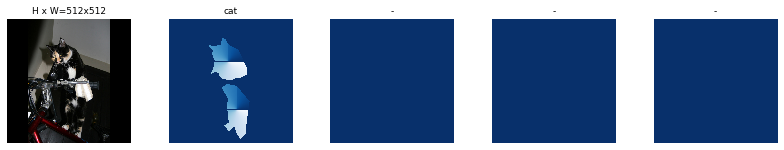

In [5]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 1)
for image_id in image_ids:
    results = dataset.prepare_image(image_id)
    if results is not None:
        image, image_meta, class_ids, bbox, mask, gt_y, gt_x, vector_mask = results
        visualize.display_top_vector_masks(image, vector_mask, class_ids, dataset.class_names)

## Display Samples

Load and display images and masks.

(427, 640, 3)
255
0
(427, 640)
12
0
(427, 640)
0
0
(427, 640)
0
0
(427, 640)
0
0


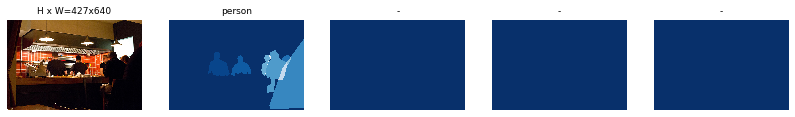

(427, 640, 3)
255
0
(427, 640)
7
0
(427, 640)
0
0
(427, 640)
0
0
(427, 640)
0
0


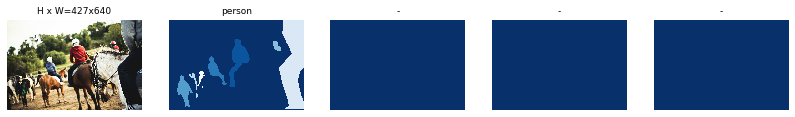

In [30]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 2)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Bounding Boxes

Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation.

(9, 2)
image_id  28313 http://cocodataset.org/#explore?id=331594
image                    shape: (416, 416, 3)         min:    0.00000  max:  253.00000  uint8
mask                     shape: (416, 416, 9)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (9,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (9, 4)                min:   53.00000  max:  274.00000  int32


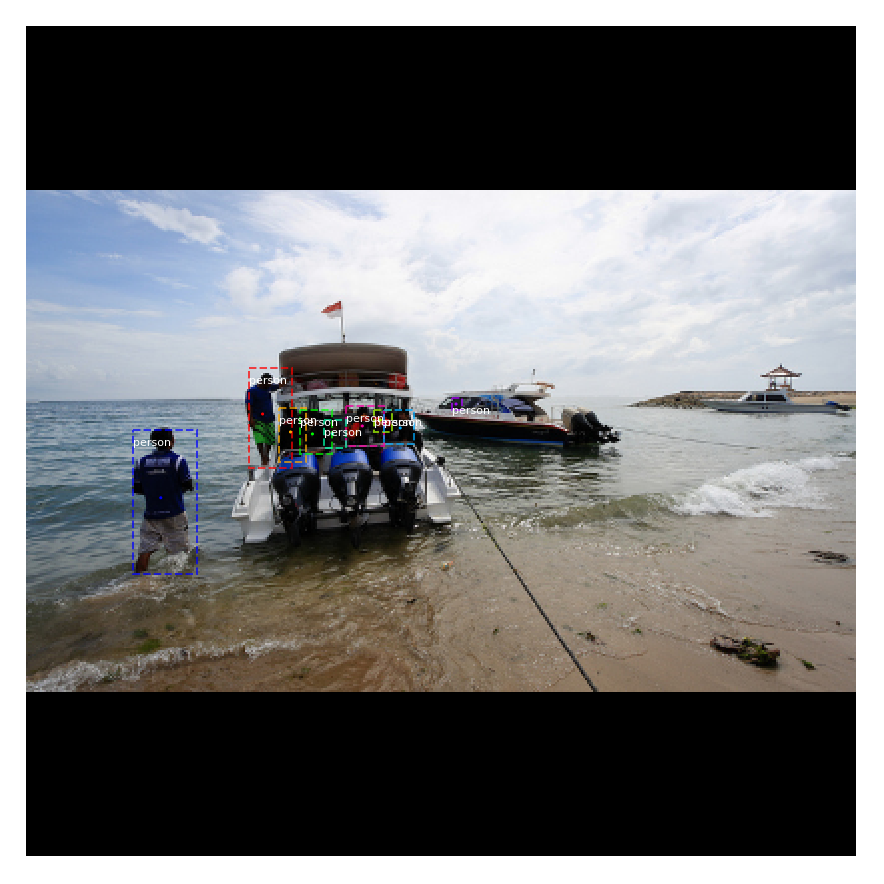

In [18]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
gt = dataset.prepare_image(image_id, augment=False, augmentation=None)
image, image_meta, class_ids, bbox, mask, gt_y, gt_x, vector_mask = gt


gt_top = np.expand_dims((gt_y - bbox[..., 0]), axis=-1)
gt_bot = np.expand_dims((bbox[..., 2] - gt_y), axis=-1)
gt_left = np.expand_dims((gt_x - bbox[..., 1]), axis=-1)
gt_right = np.expand_dims((bbox[..., 3] - gt_x), axis=-1)
gt_y = np.expand_dims(gt_y, axis=-1)
gt_x = np.expand_dims(gt_x, axis=-1)
ids = np.expand_dims(class_ids, axis=-1)
# print("picture class_ids: ", class_ids)
gt_basic = [gt_y, gt_x, gt_top, gt_left, gt_bot, gt_right, ids]
ground_truth = np.concatenate(gt_basic, axis=-1)

centers = np.concatenate([gt_y,gt_x], axis=-1)
print(np.shape(centers))
ngbbox_tlbr = ground_truth[..., [2,3,4,5]]

bbox = np.concatenate([centers - ngbbox_tlbr[..., 0:2], centers + ngbbox_tlbr[..., 2:4]], axis=-1)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, centers, bbox, mask, class_ids - 1, dataset.class_names)

## Resize Images

To support multiple images per batch, images are resized to one size (1024x1024). Aspect ratio is preserved, though. If an image is not square, then zero padding is added at the top/bottom or right/left.

image_id:  27091 http://cocodataset.org/#explore?id=329179
Original shape:  (360, 640, 3)
image                    shape: (512, 512, 3)         min:    0.00000  max:  225.00000  uint8
mask                     shape: (512, 512, 13)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (13,)                 min:   77.00000  max:   77.00000  int32
bbox                     shape: (13, 4)               min:    1.00000  max:  512.00000  int32


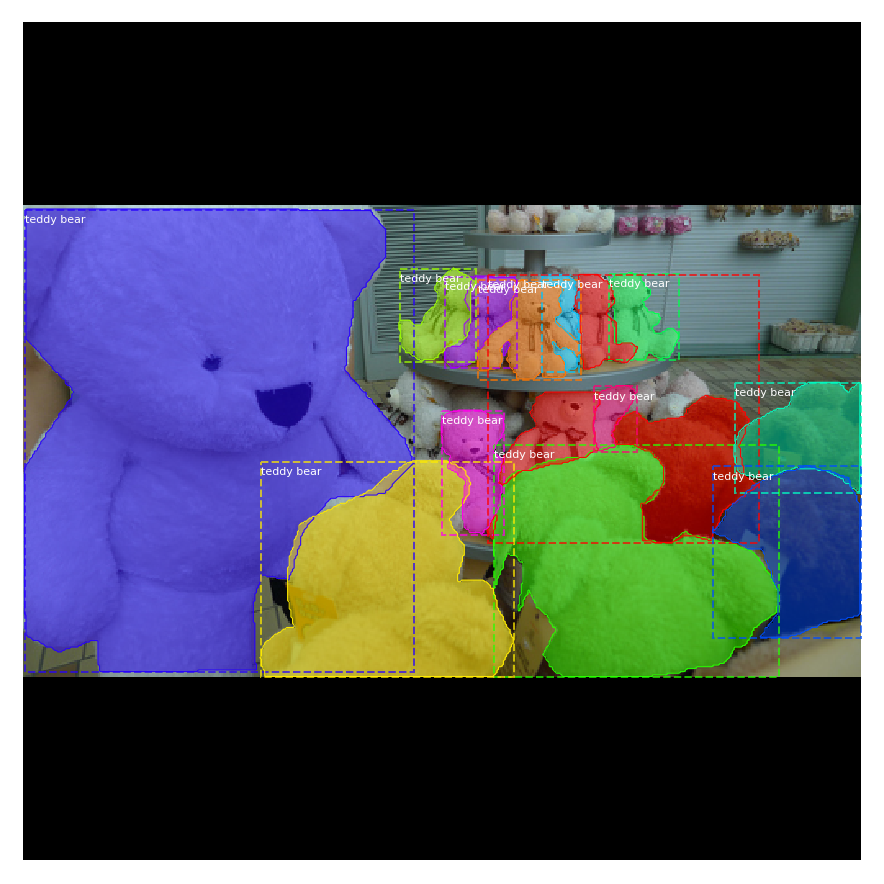

In [18]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Data Generator


In [13]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [14]:
# Uncomment to run the generator through a lot of images
# to catch rare errors
# for i in range(1000):
#     print(i)
#     _, _ = next(g)

In [15]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


rois                     shape: (4, 128, 4)           min:    0.00000  max: 1023.00000
mrcnn_class_ids          shape: (4, 128, 1)           min:    0.00000  max:   67.00000
mrcnn_bbox               shape: (4, 128, 81, 5)       min:   -3.58824  max:    3.45455
mrcnn_mask               shape: (4, 128, 28, 28, 81)  min:    0.00000  max:    1.00000
gt_boxes                 shape: (4, 100, 5)           min:    0.00000  max: 1024.00000
gt_masks                 shape: (4, 56, 56, 100)      min:    0.00000  max:    1.00000
rpn_match                shape: (4, 65472, 1)         min:   -1.00000  max:    1.00000
rpn_bbox                 shape: (4, 256, 4)           min:   -4.60969  max:    1.76777
image_id:  2937 http://cocodataset.org/#explore?id=135453


anchors                  shape: (65472, 4)            min: -362.03867  max: 1258.03867
refined_anchors          shape: (4, 4)                min:  112.99997  max:  912.00000
Positive anchors: 4
Negative anchors: 252
Neutral anchors: 65216
BG                     : 90
chair                  : 6
bed                    : 30
remote                 : 2


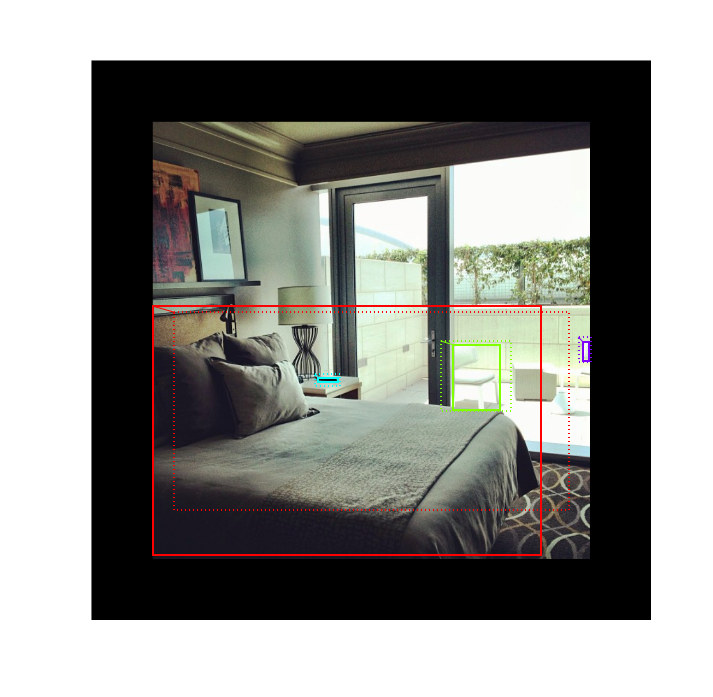

In [16]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors)

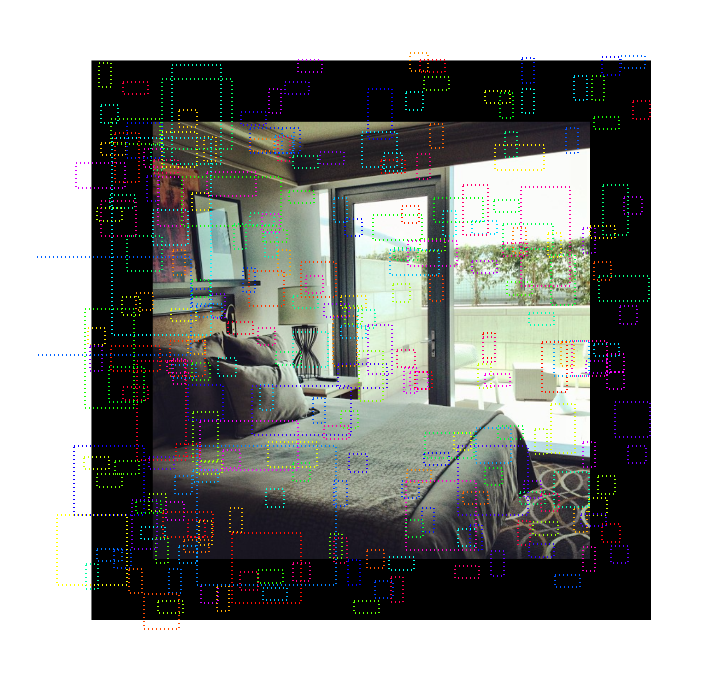

In [17]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

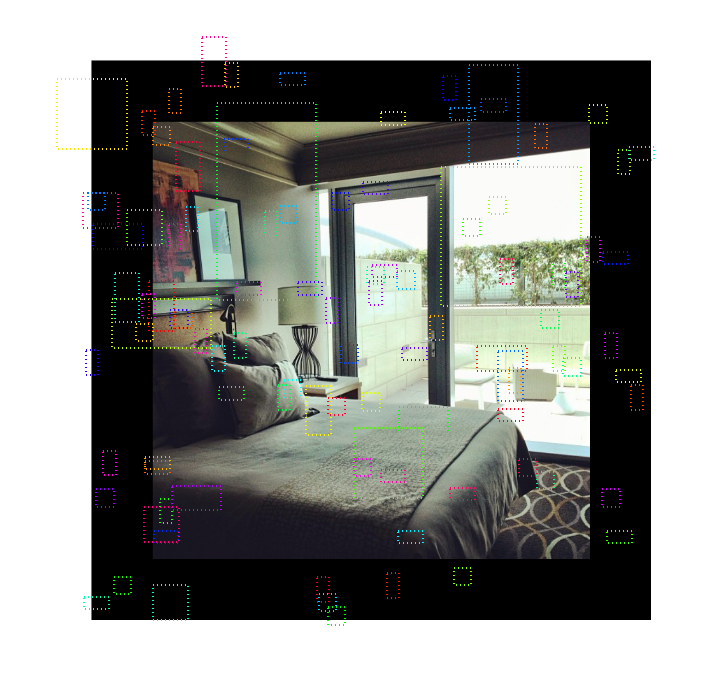

In [18]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

Positive ROIs:  38
Negative ROIs:  90
Positive Ratio: 0.30
Unique ROIs: 128 out of 128


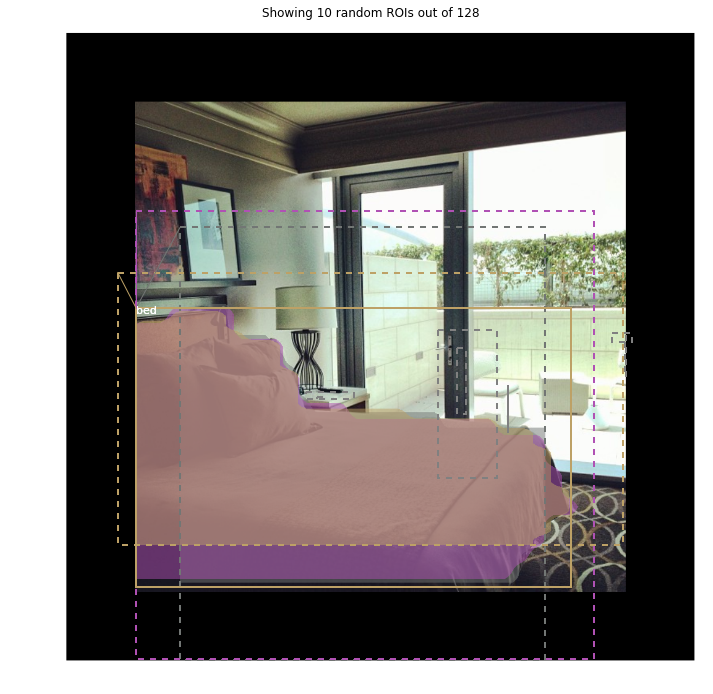

In [19]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

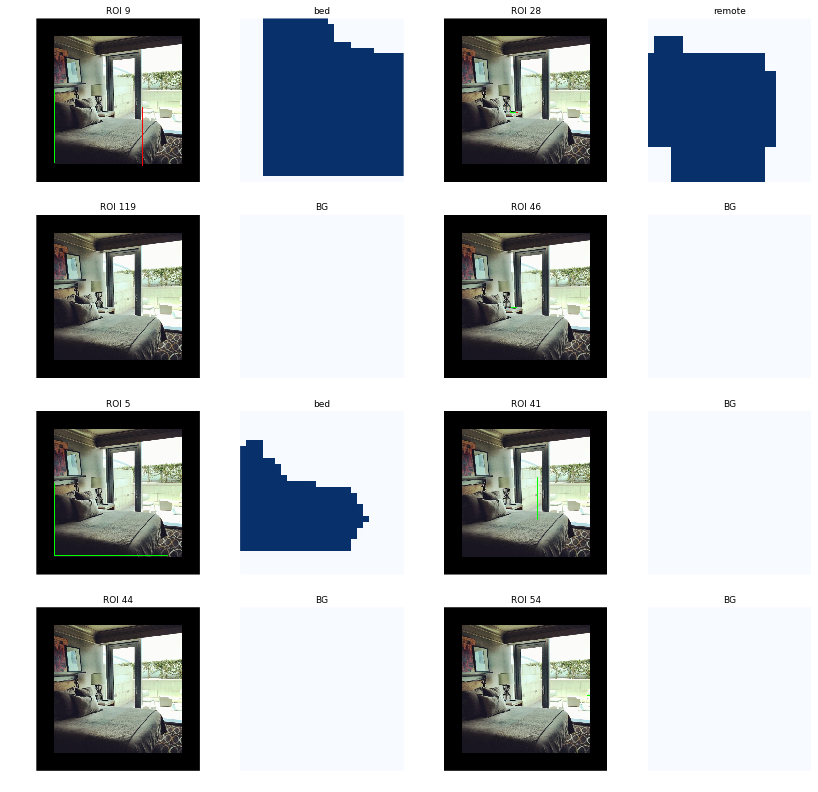

In [20]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [21]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   42  0.33
   42  0.33


/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


   42  0.33
   42  0.33
   42  0.33
   42  0.33
   42  0.33
   42  0.33
   42  0.33
   42  0.33
Average percent: 0.33
